# 🤖 Robot Odometry Trajectory Analysis

Simple and clean analysis of robot trajectories from ROS2 odometry data.

### Data Sources:
- **Odometry**: `/robomaster/odom` (position and velocities)
- **IMU**: `/robomaster/imu` (orientation data)

### Analysis Output:
- 2D trajectory visualization
- Position and orientation over time
- Movement statistics

In [47]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ROS2 bag reading
try:
    import rosbag2_py
    from rclpy.serialization import deserialize_message
    from rosidl_runtime_py.utilities import get_message
    print("✅ ROS2 libraries loaded")
except ImportError:
    print("❌ ROS2 libraries not found!")
    print("Run: source /opt/ros/humble/setup.bash")

# Configure plotting
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 11
plt.style.use('default')

print("🤖 Ready for odometry analysis!")

✅ ROS2 libraries loaded
🤖 Ready for odometry analysis!


In [48]:
# Configuration - Update your bag file path
BAG_FILE = "/home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/"

# Verify bag exists
if os.path.exists(BAG_FILE):
    print(f"✅ Bag found: {BAG_FILE}")
else:
    print(f"❌ Bag not found: {BAG_FILE}")
    print("Update BAG_FILE path above")

print("\n📊 Expected topics:")
print("   • /robomaster/odom (odometry data)")
print("   • /robomaster/imu (orientation)")

✅ Bag found: /home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/

📊 Expected topics:
   • /robomaster/odom (odometry data)
   • /robomaster/imu (orientation)


In [49]:
# Read odometry data from bag
def read_odometry_data(bag_path):
    """Extract odometry data from ROS2 bag"""
    if not os.path.exists(bag_path):
        return []
    
    odom_data = []
    
    try:
        reader = rosbag2_py.SequentialReader()
        reader.open(
            rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3'),
            rosbag2_py.ConverterOptions(
                input_serialization_format='cdr',
                output_serialization_format='cdr'
            )
        )
        
        # Read odometry topic
        storage_filter = rosbag2_py.StorageFilter(topics=['/robomaster/odom'])
        reader.set_filter(storage_filter)
        
        odom_msg_type = get_message('nav_msgs/msg/Odometry')
        
        while reader.has_next():
            topic, data, timestamp = reader.read_next()
            odom_msg = deserialize_message(data, odom_msg_type)
            
            # Extract position
            x = odom_msg.pose.pose.position.x
            y = odom_msg.pose.pose.position.y
            
            # Extract orientation (quaternion to yaw)
            qx = odom_msg.pose.pose.orientation.x
            qy = odom_msg.pose.pose.orientation.y
            qz = odom_msg.pose.pose.orientation.z
            qw = odom_msg.pose.pose.orientation.w
            yaw = np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))
            
            # Extract velocities
            vx = odom_msg.twist.twist.linear.x
            vy = odom_msg.twist.twist.linear.y
            wz = odom_msg.twist.twist.angular.z
            
            odom_data.append({
                'timestamp': timestamp / 1e9,
                'x': x,
                'y': y,
                'yaw': yaw,
                'yaw_deg': np.degrees(yaw),
                'vx': vx,
                'vy': vy,
                'wz': wz,
                'speed': np.sqrt(vx*vx + vy*vy)
            })
            
    except Exception as e:
        print(f"❌ Error reading odometry: {e}")
        return []
    
    print(f"✅ Read {len(odom_data)} odometry points")
    return odom_data

print("✅ Odometry reader ready")

✅ Odometry reader ready


In [50]:
# Read event data from bag
def read_event_data(bag_path):
    """Extract event data from ROS2 bag"""
    if not os.path.exists(bag_path):
        return []
    
    event_data = []
    
    try:
        reader = rosbag2_py.SequentialReader()
        reader.open(
            rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3'),
            rosbag2_py.ConverterOptions(
                input_serialization_format='cdr',
                output_serialization_format='cdr'
            ),
        )
        
        # Read experiment events topic
        storage_filter = rosbag2_py.StorageFilter(topics=['/experiment/event'])
        reader.set_filter(storage_filter)
        
        # Try different message types that might be used for events
        try:
            event_msg_type = get_message('std_msgs/msg/String')
        except:
            try:
                event_msg_type = get_message('geometry_msgs/msg/Twist')  # fallback
            except:
                print("⚠️ Could not determine event message type")
                return []
        
        while reader.has_next():
            topic, data, timestamp = reader.read_next()
            try:
                event_msg = deserialize_message(data, event_msg_type)
                
                # Parse event message (assuming it's a JSON string in std_msgs/String)
                if hasattr(event_msg, 'data'):
                    import json
                    try:
                        event_json = json.loads(event_msg.data)
                        event_data.append({
                            'timestamp': timestamp / 1e9,
                            'event_type': event_json.get('event_type', 'unknown'),
                            'action': event_json.get('action', 'unknown'),
                            'details': event_json.get('details', {}),
                            'session_id': event_json.get('session_id', '')
                        })
                    except json.JSONDecodeError:
                        # If not JSON, treat as plain string
                        event_data.append({
                            'timestamp': timestamp / 1e9,
                            'event_type': 'raw_message',
                            'action': 'message',
                            'details': {'message': event_msg.data},
                            'session_id': ''
                        })
                        
            except Exception as e:
                print(f"⚠️ Error parsing event message: {e}")
                continue
                
    except Exception as e:
        print(f"❌ Error reading events: {e}")
        return []
    
    print(f"✅ Read {len(event_data)} event messages")
    return event_data

# Alternative: Read from JSONL file if bag reading fails
def read_event_data_from_jsonl(bag_path):
    """Fallback: read events from JSONL file"""
    import json
    from pathlib import Path
    
    # Try to find matching JSONL file
    bag_name = Path(bag_path).name
    jsonl_path = Path(bag_path).parent.parent / "experiment_logs" / f"{bag_name}.jsonl"
    
    if not jsonl_path.exists():
        print(f"⚠️ No JSONL file found at: {jsonl_path}")
        return []
    
    event_data = []
    try:
        with open(jsonl_path, 'r') as f:
            for line in f:
                if line.strip():
                    event_json = json.loads(line.strip())
                    # Convert ISO timestamp to Unix timestamp
                    from datetime import datetime
                    iso_time = event_json.get('timestamp', '')
                    unix_time = datetime.fromisoformat(iso_time.replace('Z', '+00:00')).timestamp()
                    
                    event_data.append({
                        'timestamp': unix_time,
                        'event_type': event_json.get('event_type', 'unknown'),
                        'action': event_json.get('action', 'unknown'),
                        'details': event_json.get('details', {}),
                        'session_id': event_json.get('session_id', '')
                    })
    except Exception as e:
        print(f"❌ Error reading JSONL: {e}")
        return []
        
    print(f"✅ Read {len(event_data)} events from JSONL file")
    return event_data

print("✅ Event data readers ready")

✅ Event data readers ready


In [51]:
# Load and analyze odometry data
print("🔄 Loading odometry data...")

odom_data = read_odometry_data(BAG_FILE)

if not odom_data:
    print("❌ No odometry data found!")
    print("Make sure /robomaster/odom is in your bag file")
else:
    # Convert to DataFrame
    df = pd.DataFrame(odom_data)
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time_rel'] = df['timestamp'] - df['timestamp'].iloc[0]
    
    # Calculate trajectory metrics
    duration = df['time_rel'].iloc[-1]
    
    # Calculate distance traveled
    distances = []
    for i in range(1, len(df)):
        dx = df['x'].iloc[i] - df['x'].iloc[i-1]
        dy = df['y'].iloc[i] - df['y'].iloc[i-1]
        distances.append(np.sqrt(dx*dx + dy*dy))
    total_distance = sum(distances)
    
    # Summary statistics
    print(f"\n🤖 TRAJECTORY SUMMARY:")
    print(f"   ⏱️  Duration: {duration:.1f} seconds")
    print(f"   📍 Data points: {len(df)}")
    print(f"   📏 Total distance: {total_distance:.2f} meters")
    print(f"   📊 X range: {df['x'].min(): .2f} to {df['x'].max(): .2f} m")
    print(f"   📊 Y range: {df['y'].min(): .2f} to {df['y'].max(): .2f} m")
    print(f"   🧭 Heading range: {df['yaw_deg'].min(): .0f}° to {df['yaw_deg'].max(): .0f}°")
    print(f"   ⚡ Max speed: {df['speed'].max(): .2f} m/s")
    print(f"   ⚡ Avg speed: {df['speed'].mean(): .2f} m/s")
    
    print(f"\n📋 First few data points:")
    print(df[['time_rel', 'x', 'y', 'yaw_deg', 'speed']].head())

🔄 Loading odometry data...
✅ Read 449 odometry points

🤖 TRAJECTORY SUMMARY:
   ⏱️  Duration: 45.8 seconds
   📍 Data points: 449
   📏 Total distance: 11.01 meters
   📊 X range:  0.27 to  2.56 m
   📊 Y range: -1.17 to  1.11 m
   🧭 Heading range: -179° to  179°
   ⚡ Max speed:  0.98 m/s
   ⚡ Avg speed:  0.27 m/s

📋 First few data points:
   time_rel        x        y  yaw_deg  speed
0  0.000000  0.68442 -0.87674    24.37   0.05
1  0.105112  0.68410 -0.87657    24.38   0.05
2  0.201517  0.68413 -0.87640    24.40   0.05
3  0.302402  0.68396 -0.87593    24.39   0.05
4  0.401430  0.68360 -0.87612    24.40   0.05
✅ Read 449 odometry points

🤖 TRAJECTORY SUMMARY:
   ⏱️  Duration: 45.8 seconds
   📍 Data points: 449
   📏 Total distance: 11.01 meters
   📊 X range:  0.27 to  2.56 m
   📊 Y range: -1.17 to  1.11 m
   🧭 Heading range: -179° to  179°
   ⚡ Max speed:  0.98 m/s
   ⚡ Avg speed:  0.27 m/s

📋 First few data points:
   time_rel        x        y  yaw_deg  speed
0  0.000000  0.68442 -0.87674

[INFO] [1757446174.366163897] [rosbag2_storage]: Opened database '/home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/test_08_2025-09-09T18-57-41-386Z_0.db3' for READ_ONLY.


In [52]:
# Load and analyze event data
print("🔄 Loading event data...")

# Try reading from ROS2 bag first, then fallback to JSONL
event_data = read_event_data(BAG_FILE)
if not event_data:
    print("⚠️ No events from bag, trying JSONL file...")
    event_data = read_event_data_from_jsonl(BAG_FILE)

if not event_data:
    print("❌ No event data found!")
    events_df = pd.DataFrame()  # Empty dataframe
else:
    # Convert to DataFrame
    events_df = pd.DataFrame(event_data)
    
    # Align timestamps with odometry (relative to start)
    if 'df' in locals() and not df.empty:
        odom_start_time = df['timestamp'].iloc[0]
        events_df['time_rel'] = events_df['timestamp'] - odom_start_time
        
        # Filter events to trajectory timespan
        trajectory_end = df['timestamp'].iloc[-1]
        events_df = events_df[
            (events_df['timestamp'] >= odom_start_time) & 
            (events_df['timestamp'] <= trajectory_end)
        ].copy()
    else:
        events_df['time_rel'] = events_df['timestamp'] - events_df['timestamp'].iloc[0]
    
    # Categorize events by type for visualization
    feedback_events = events_df[events_df['event_type'] == 'system'].copy()
    led_events = events_df[events_df['event_type'] == 'led_control'].copy()
    sound_events = events_df[events_df['event_type'] == 'sound_control'].copy()
    movement_events = events_df[events_df['event_type'] == 'movement'].copy()
    
    # Summary statistics
    print(f"\n🎯 EVENT SUMMARY:")
    print(f"   📊 Total events: {len(events_df)}")
    print(f"   🎭 System feedback: {len(feedback_events)}")
    print(f"   💡 LED controls: {len(led_events)}")
    print(f"   🔊 Sound events: {len(sound_events)}")
    print(f"   🤖 Movement events: {len(movement_events)}")
    
    # Show interesting events
    positive_feedback = events_df[events_df['action'] == 'positive_feedback']
    if len(positive_feedback) > 0:
        print(f"   ✅ Positive feedback events: {len(positive_feedback)}")
        print(f"      Times: {positive_feedback['time_rel'].round(1).tolist()[:5]} seconds")
    
    negative_feedback = events_df[events_df['action'].str.contains('negative|bad', na=False)]
    if len(negative_feedback) > 0:
        print(f"   ❌ Negative feedback events: {len(negative_feedback)}")
    
    print(f"\n📋 Event types found:")
    print(events_df['action'].value_counts().head(10))

🔄 Loading event data...
✅ Read 121 event messages

🎯 EVENT SUMMARY:
   📊 Total events: 121
   🎭 System feedback: 2
   💡 LED controls: 45
   🔊 Sound events: 16
   🤖 Movement events: 58
   ✅ Positive feedback events: 2
      Times: [12.6, 30.8] seconds

📋 Event types found:
action
joystick_move           42
set_color               42
play_sound              14
joystick_end             6
joystick_start           6
feedback_blink           3
positive_feedback        2
rotate_on_spot           2
happy_chime_sequence     2
generic_action           1
Name: count, dtype: int64


[INFO] [1757446174.624140099] [rosbag2_storage]: Opened database '/home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/test_08_2025-09-09T18-57-41-386Z_0.db3' for READ_ONLY.


In [53]:
# Function to find robot position at event times
def get_robot_position_at_events(odom_df, events_df):
    """Find robot position when each event occurred"""
    event_positions = []
    
    for _, event in events_df.iterrows():
        event_time = event['timestamp']
        
        # Find closest odometry point
        time_diffs = np.abs(odom_df['timestamp'] - event_time)
        closest_idx = time_diffs.idxmin()
        
        if time_diffs.iloc[closest_idx] < 1.0:  # Within 1 second
            robot_pos = {
                'event_time': event['time_rel'],
                'event_type': event['event_type'],
                'action': event['action'],
                'x': odom_df.loc[closest_idx, 'x'],
                'y': odom_df.loc[closest_idx, 'y'],
                'yaw': odom_df.loc[closest_idx, 'yaw'],
                'details': event.get('details', {})
            }
            event_positions.append(robot_pos)
    
    return pd.DataFrame(event_positions)

# Get event positions
if 'df' in locals() and 'events_df' in locals() and not events_df.empty:
    event_positions = get_robot_position_at_events(df, events_df)
    print(f"✅ Mapped {len(event_positions)} events to robot positions")
    
    if len(event_positions) > 0:
        print(f"\n📍 Events on trajectory:")
        for event_type in event_positions['event_type'].unique():
            count = len(event_positions[event_positions['event_type'] == event_type])
            print(f"   • {event_type}: {count} events")
else:
    event_positions = pd.DataFrame()
    print("❌ No events to map to positions")

✅ Mapped 121 events to robot positions

📍 Events on trajectory:
   • movement: 58 events
   • system: 2 events
   • led_control: 45 events
   • sound_control: 16 events
   • movement: 58 events
   • system: 2 events
   • led_control: 45 events
   • sound_control: 16 events


/tmp/ipykernel_55816/1758874579.py:95: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/1758874579.py:95: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/1758874579.py:95: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/davide/hogwarts/ros-server/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/davide/hogwarts/ros-server/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/davide/hogwarts/ros-server/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing fr

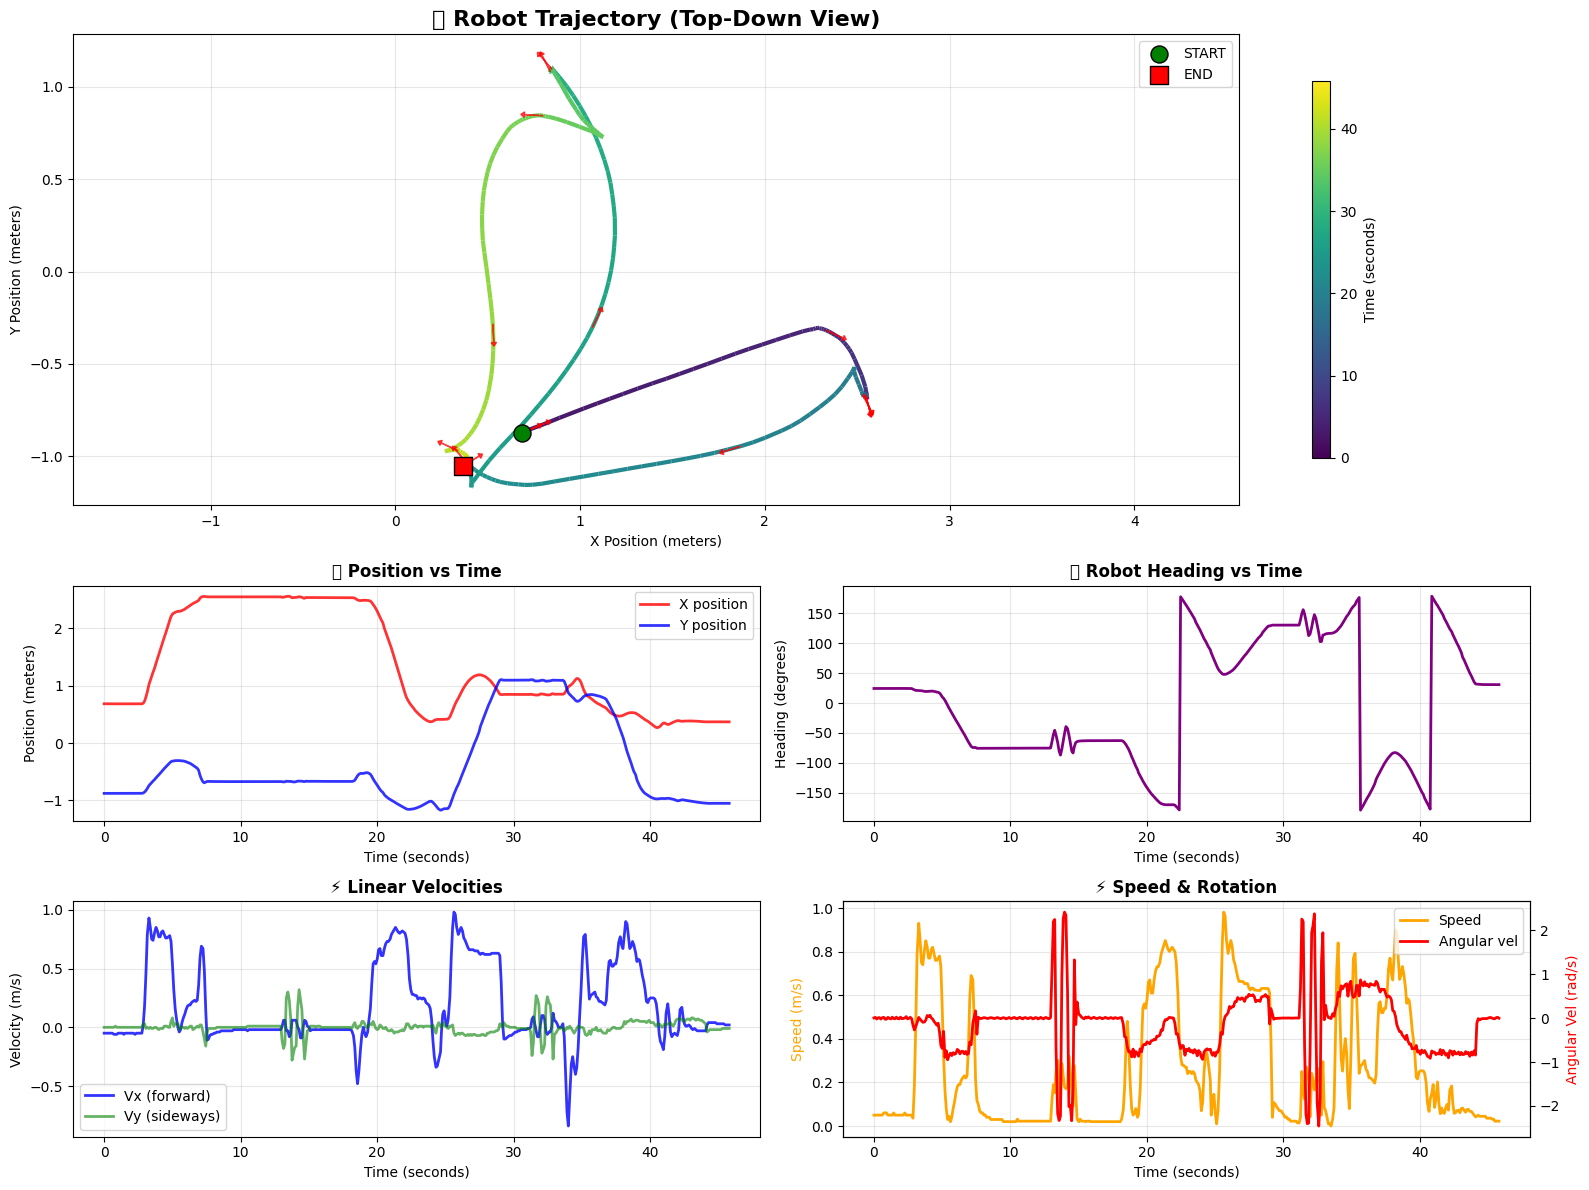

✅ Trajectory visualization complete!

📊 Plot explanation:
   • Top: 2D path with time progression (dark→light = start→end)
   • Red arrows show robot orientation
   • Middle: Position and heading changes over time
   • Bottom: Velocity profiles


In [54]:
# Visualize trajectory
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # 1. Main 2D trajectory plot
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=150, marker='o', label='START', zorder=10, edgecolor='black')
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=150, marker='s', label='END', zorder=10, edgecolor='black')
    
    # Add orientation arrows
    N = max(1, len(df) // 15)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.1
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.03, head_length=0.02, 
                 fc='red', ec='red', alpha=0.7, zorder=5)
    
    ax1.set_title('🗺️ Robot Trajectory (Top-Down View)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Colorbar
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    # 2. Position vs Time
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df['time_rel'], df['x'], 'r-', linewidth=2, label='X position', alpha=0.8)
    ax2.plot(df['time_rel'], df['y'], 'b-', linewidth=2, label='Y position', alpha=0.8)
    ax2.set_title('📍 Position vs Time', fontweight='bold')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Position (meters)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Heading vs Time
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(df['time_rel'], df['yaw_deg'], 'purple', linewidth=2)
    ax3.set_title('🧭 Robot Heading vs Time', fontweight='bold')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Heading (degrees)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Velocities
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df['time_rel'], df['vx'], 'b-', linewidth=2, label='Vx (forward)', alpha=0.8)
    ax4.plot(df['time_rel'], df['vy'], 'g-', linewidth=2, label='Vy (sideways)', alpha=0.6)
    ax4.set_title('⚡ Linear Velocities', fontweight='bold')
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Velocity (m/s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Speed and Angular Velocity
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(df['time_rel'], df['speed'], 'orange', linewidth=2, label='Speed')
    ax5_twin = ax5.twinx()
    ax5_twin.plot(df['time_rel'], df['wz'], 'red', linewidth=2, label='Angular vel')
    ax5.set_title('⚡ Speed & Rotation', fontweight='bold')
    ax5.set_xlabel('Time (seconds)')
    ax5.set_ylabel('Speed (m/s)', color='orange')
    ax5_twin.set_ylabel('Angular Vel (rad/s)', color='red')
    ax5.grid(True, alpha=0.3)
    
    # Combined legend
    lines1, labels1 = ax5.get_legend_handles_labels()
    lines2, labels2 = ax5_twin.get_legend_handles_labels()
    ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Trajectory visualization complete!")
    print("\n📊 Plot explanation:")
    print("   • Top: 2D path with time progression (dark→light = start→end)")
    print("   • Red arrows show robot orientation")
    print("   • Middle: Position and heading changes over time")
    print("   • Bottom: Velocity profiles")
    
else:
    print("❌ No trajectory data to visualize")

/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 128154 (\N{GREEN HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/2670796595.py:175: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu 

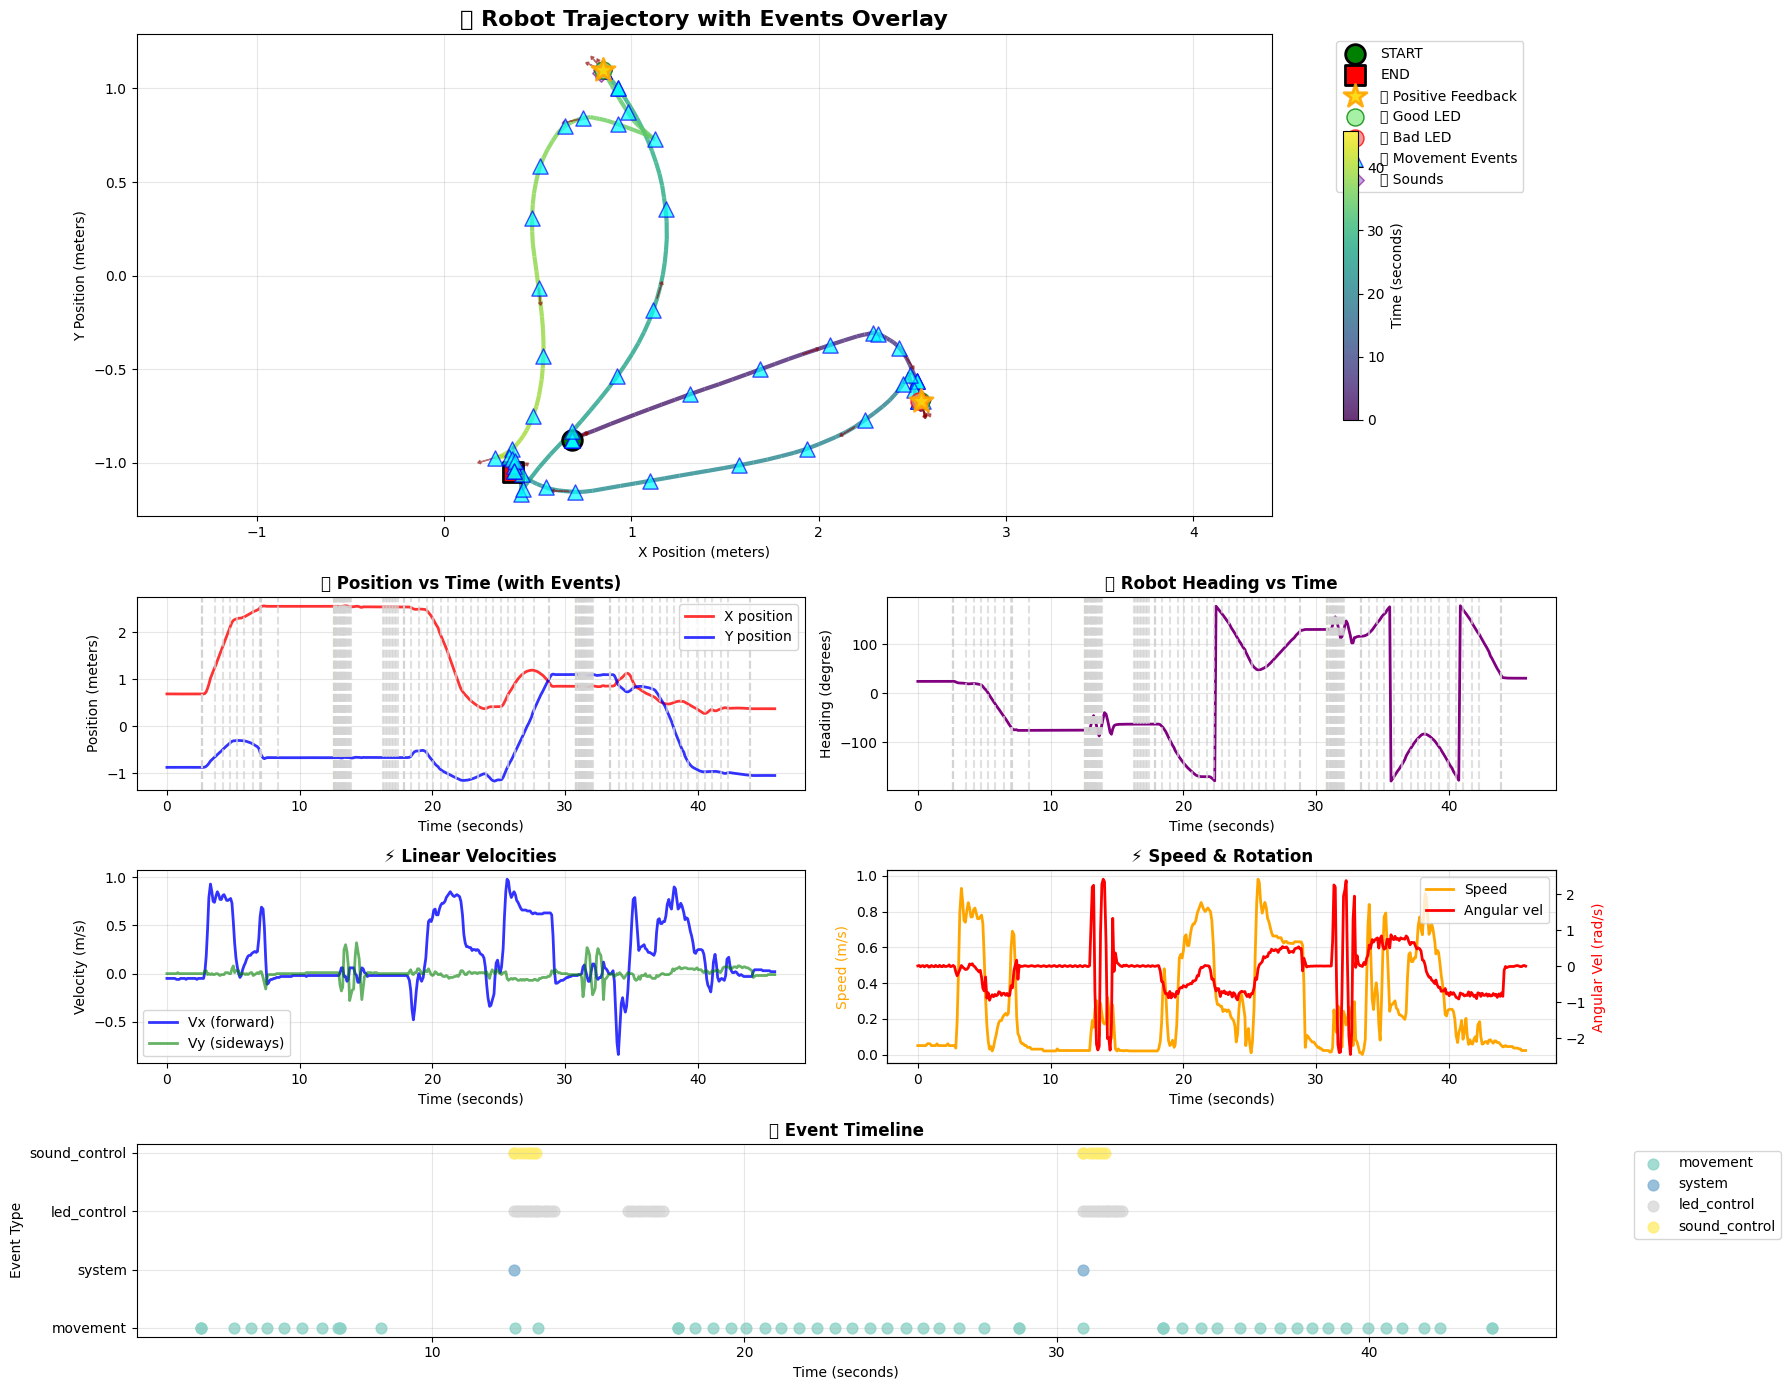

✅ Enhanced trajectory visualization complete!

📊 Plot explanation:
   • Top: 2D trajectory with event markers overlaid
   • ★ Gold stars = Positive feedback events
   • ● Green/Red circles = LED feedback (good/bad)
   • ↻ Cyan circles = Movement events
   • ♪ Purple dots = Sound events
   • Bottom: Complete event timeline


In [55]:
# Enhanced trajectory visualization with events
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 2, height_ratios=[2.5, 1, 1, 1])
    
    # 1. Main 2D trajectory plot with events
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3, alpha=0.8)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=200, marker='o', label='START', zorder=10, 
               edgecolor='black', linewidth=2)
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=200, marker='s', label='END', zorder=10, 
               edgecolor='black', linewidth=2)
    
    # Add event markers
    if 'event_positions' in locals() and not event_positions.empty:
        
        # Positive feedback events
        positive = event_positions[event_positions['action'] == 'positive_feedback']
        if len(positive) > 0:
            ax1.scatter(positive['x'], positive['y'], 
                       color='gold', s=300, marker='*', label='✅ Positive Feedback', 
                       zorder=15, edgecolor='orange', linewidth=2, alpha=0.9)
        
        # LED feedback events
        led_feedback = event_positions[event_positions['action'] == 'feedback_blink']
        if len(led_feedback) > 0:
            # Separate good vs bad feedback
            good_led = led_feedback[led_feedback['details'].astype(str).str.contains('good')]
            bad_led = led_feedback[led_feedback['details'].astype(str).str.contains('bad')]
            
            if len(good_led) > 0:
                ax1.scatter(good_led['x'], good_led['y'], 
                           color='lightgreen', s=150, marker='o', label='💚 Good LED', 
                           zorder=12, edgecolor='green', linewidth=1, alpha=0.8)
            if len(bad_led) > 0:
                ax1.scatter(bad_led['x'], bad_led['y'], 
                           color='lightcoral', s=150, marker='o', label='💔 Bad LED', 
                           zorder=12, edgecolor='red', linewidth=1, alpha=0.8)
        
        # Movement events
        movement = event_positions[event_positions['event_type'] == 'movement']
        if len(movement) > 0:
            ax1.scatter(movement['x'], movement['y'], 
                       color='cyan', s=120, marker='^', label='🔄 Movement Events', 
                       zorder=11, edgecolor='blue', linewidth=1, alpha=0.7)
        
        # Sound events
        sounds = event_positions[event_positions['event_type'] == 'sound_control']
        if len(sounds) > 0:
            ax1.scatter(sounds['x'], sounds['y'], 
                       color='mediumpurple', s=80, marker='D', label='🎵 Sounds', 
                       zorder=11, edgecolor='purple', linewidth=1, alpha=0.6)
    
    # Add orientation arrows (fewer to avoid clutter)
    N = max(1, len(df) // 20)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.08
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.02, head_length=0.015, 
                 fc='darkred', ec='darkred', alpha=0.5, zorder=5)
    
    ax1.set_title('🗺️ Robot Trajectory with Events Overlay', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.axis('equal')
    
    # Colorbar for trajectory time
    cbar = plt.colorbar(line, ax=ax1, shrink=0.6)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    # 2. Position vs Time with event markers
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df['time_rel'], df['x'], 'r-', linewidth=2, label='X position', alpha=0.8)
    ax2.plot(df['time_rel'], df['y'], 'b-', linewidth=2, label='Y position', alpha=0.8)
    
    # Add event vertical lines
    if 'event_positions' in locals() and not event_positions.empty:
        for _, event in event_positions.iterrows():
            color = 'gold' if event['action'] == 'positive_feedback' else 'lightgray'
            ax2.axvline(event['event_time'], color=color, alpha=0.7, linestyle='--')
    
    ax2.set_title('📍 Position vs Time (with Events)', fontweight='bold')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Position (meters)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Heading vs Time with events
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(df['time_rel'], df['yaw_deg'], 'purple', linewidth=2)
    
    # Add event markers
    if 'event_positions' in locals() and not event_positions.empty:
        for _, event in event_positions.iterrows():
            color = 'gold' if event['action'] == 'positive_feedback' else 'lightgray'
            ax3.axvline(event['event_time'], color=color, alpha=0.7, linestyle='--')
    
    ax3.set_title('🧭 Robot Heading vs Time', fontweight='bold')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Heading (degrees)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Velocities
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df['time_rel'], df['vx'], 'b-', linewidth=2, label='Vx (forward)', alpha=0.8)
    ax4.plot(df['time_rel'], df['vy'], 'g-', linewidth=2, label='Vy (sideways)', alpha=0.6)
    ax4.set_title('⚡ Linear Velocities', fontweight='bold')
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Velocity (m/s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Speed and Angular Velocity
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(df['time_rel'], df['speed'], 'orange', linewidth=2, label='Speed')
    ax5_twin = ax5.twinx()
    ax5_twin.plot(df['time_rel'], df['wz'], 'red', linewidth=2, label='Angular vel')
    ax5.set_title('⚡ Speed & Rotation', fontweight='bold')
    ax5.set_xlabel('Time (seconds)')
    ax5.set_ylabel('Speed (m/s)', color='orange')
    ax5_twin.set_ylabel('Angular Vel (rad/s)', color='red')
    ax5.grid(True, alpha=0.3)
    
    # Combined legend
    lines1, labels1 = ax5.get_legend_handles_labels()
    lines2, labels2 = ax5_twin.get_legend_handles_labels()
    ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # 6. Event Timeline
    ax6 = fig.add_subplot(gs[3, :])
    if 'events_df' in locals() and not events_df.empty:
        # Create event timeline
        event_types = events_df['event_type'].unique()
        colors = plt.cm.Set3(np.linspace(0, 1, len(event_types)))
        
        for i, event_type in enumerate(event_types):
            type_events = events_df[events_df['event_type'] == event_type]
            ax6.scatter(type_events['time_rel'], [i] * len(type_events), 
                       color=colors[i], s=60, alpha=0.8, label=event_type)
        
        ax6.set_title('📅 Event Timeline', fontweight='bold')
        ax6.set_xlabel('Time (seconds)')
        ax6.set_ylabel('Event Type')
        ax6.set_yticks(range(len(event_types)))
        ax6.set_yticklabels(event_types)
        ax6.grid(True, alpha=0.3)
        ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax6.text(0.5, 0.5, 'No event data available', 
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('📅 Event Timeline (No Data)', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Enhanced trajectory visualization complete!")
    print("\n📊 Plot explanation:")
    print("   • Top: 2D trajectory with event markers overlaid")
    print("   • ★ Gold stars = Positive feedback events")
    print("   • ● Green/Red circles = LED feedback (good/bad)")
    print("   • ↻ Cyan circles = Movement events")
    print("   • ♪ Purple dots = Sound events")
    print("   • Bottom: Complete event timeline")
    
else:
    print("❌ No trajectory data to visualize")